
# Support Vector Regression (SVR) — From Theory to Practice

This notebook gives you a full, self-contained walkthrough of **Support Vector Regression (SVR)**:
- Intuition and **mathematical formulation** (primal, dual, and kernels)
- The **$\epsilon$-insensitive loss** and the role of **$C$** and **$\epsilon$**
- A **hands-on implementation** using scikit-learn
- **Visualization** of fits, residuals, support vectors, and hyperparameter effects



## 1) SVR in a Nutshell

**Goal.** Given training data $\{(\mathbf{x}_i, y_i)\}_{i=1}^n$ with $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$, we learn a function $f(\mathbf{x})$ that predicts $y$ from $\mathbf{x}$ while being as **flat** as possible and ignoring small errors up to a tolerance $\epsilon$.

### 1.1 $\epsilon$-insensitive loss

The **$\epsilon$-insensitive loss** behaves like a tube of radius $\epsilon$ around the regressor: deviations inside the tube cost nothing; deviations outside cost linearly.
$$
L_\epsilon(y, f(\mathbf{x})) \;=\;
\max\bigl\{0,\; |y - f(\mathbf{x})| - \epsilon \bigr\}.
$$

### 1.2 Primal formulation (linear SVR in feature space)

Let $\phi(\cdot)$ be a feature map (possibly implicit via a kernel). The **primal** is:
$$
\begin{aligned}
\min_{\mathbf{w},\, b,\, \boldsymbol{\xi},\, \boldsymbol{\xi}^*}\;&
\frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^{n} (\xi_i + \xi_i^*)\\
\text{s.t.}\;&
y_i - \mathbf{w}^\top \phi(\mathbf{x}_i) - b \le \epsilon + \xi_i,\\
& \mathbf{w}^\top \phi(\mathbf{x}_i) + b - y_i \le \epsilon + \xi_i^*,\\
& \xi_i \ge 0,\;\; \xi_i^* \ge 0,\quad i=1,\dots,n.
\end{aligned}
$$

- $C>0$ trades off **flatness** vs. **penalizing errors** outside the $\epsilon$-tube.
- $\epsilon \ge 0$ sets the tube **width** (robustness vs. fidelity).

### 1.3 Dual formulation and kernels

Introducing Lagrange multipliers $\alpha_i, \alpha_i^* \in [0,C]$ and eliminating primal variables yields the **dual** QP:
$$
\begin{aligned}
\max_{\boldsymbol{\alpha}, \boldsymbol{\alpha}^*}\;&
- \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^n (\alpha_i - \alpha_i^*)(\alpha_j - \alpha_j^*)\,K(\mathbf{x}_i,\mathbf{x}_j)\\
&\quad - \epsilon \sum_{i=1}^{n} (\alpha_i + \alpha_i^*) + \sum_{i=1}^{n} y_i (\alpha_i - \alpha_i^*)\\
\text{s.t.}\;&
\sum_{i=1}^{n} (\alpha_i - \alpha_i^*) = 0,\quad 0 \le \alpha_i, \alpha_i^* \le C,
\end{aligned}
$$
where $K(\mathbf{x},\mathbf{z}) = \phi(\mathbf{x})^\top \phi(\mathbf{z})$ is a **kernel** (e.g., linear, polynomial, RBF).

The regressor is
$$
f(\mathbf{x}) = \sum_{i=1}^{n} (\alpha_i - \alpha_i^*)\,K(\mathbf{x}_i,\mathbf{x}) + b,
$$
and the **support vectors** are those with $(\alpha_i - \alpha_i^*) \neq 0$.

### 1.4 KKT conditions (intuition)
At optimum, Karush–Kuhn–Tucker conditions imply:
- Points **inside** the $\epsilon$-tube have $\alpha_i = \alpha_i^* = 0$ (non-support).
- Points **on** or **outside** the tube can have $0 < \alpha_i \text{ or } \alpha_i^* < C$ (support vectors).
- Points with **maxed** slack may hit the box constraint $\alpha_i$ or $\alpha_i^* = C$.



## 2) Practical Setup

We'll demonstrate SVR on a noisy nonlinear 1D problem, and then compare kernels and hyperparameters.

**Environment (one-time if needed):**
```bash
pip install numpy scipy scikit-learn matplotlib pandas
```


In [1]:

# 2.1 Imports and configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)


In [2]:

# 2.2 Generate a synthetic nonlinear regression dataset
n = 250
X = np.linspace(-3, 3, n).reshape(-1, 1)
y_true = np.sinc(X).ravel()  # sin(pi x)/(pi x) shape
noise = 0.1 * np.random.randn(n)
y = y_true + noise

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print(X_train.shape, X_test.shape)


(187, 1) (63, 1)



## 3) Fit an RBF-kernel SVR (with basic tuning)

We will tune $(C, \epsilon, \gamma)$ using a small grid search.


In [3]:

# 3.1 Small grid search for RBF SVR
param_grid = {
    "C": [0.5, 1.0, 10.0, 100.0],
    "epsilon": [0.01, 0.05, 0.1, 0.2],
    "gamma": ["scale", 0.1, 0.5, 1.0]
}

svr = SVR(kernel="rbf")
gcv = GridSearchCV(svr, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
gcv.fit(X_train, y_train)

best_svr = gcv.best_estimator_
best_svr


SVR(C=100.0, epsilon=0.01, gamma=1.0)

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def safe_rmse(y_true, y_pred):
    try:
        # Newer sklearn (>=0.22) supports squared=False
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # Older sklearn: compute RMSE manually
        return np.sqrt(mean_squared_error(y_true, y_pred))

def evaluate(model, X_tr, y_tr, X_te, y_te, label="SVR"):
    # Ensure 1D targets (avoids shape warnings in some versions)
    y_tr = np.ravel(y_tr)
    y_te = np.ravel(y_te)

    yhat_tr = model.predict(X_tr)
    yhat_te = model.predict(X_te)

    metrics = {
        "Model": label,
        "MAE_train": mean_absolute_error(y_tr, yhat_tr),
        "RMSE_train": safe_rmse(y_tr, yhat_tr),
        "R2_train": r2_score(y_tr, yhat_tr),
        "MAE_test": mean_absolute_error(y_te, yhat_te),
        "RMSE_test": safe_rmse(y_te, yhat_te),
        "R2_test": r2_score(y_te, yhat_te),
    }
    return metrics, yhat_tr, yhat_te

metrics_rbf, yhat_tr, yhat_te = evaluate(best_svr, X_train, y_train, X_test, y_test, label="SVR-RBF (tuned)")
pd.DataFrame([metrics_rbf])


,Model,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test
0,SVR-RBF (tuned),0.070002,0.092929,0.937364,0.08257,0.10346,0.918826


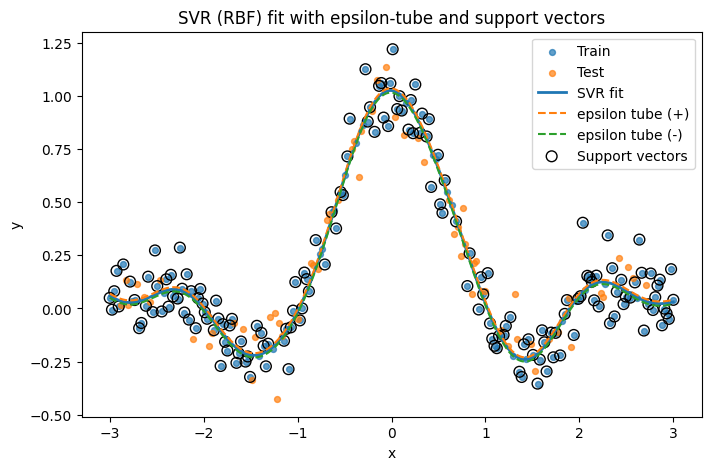

In [6]:

# 3.3 Visualize the fit, tube, and support vectors
# Create dense grid
Xd = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
yhat_d = best_svr.predict(Xd)

plt.figure(figsize=(8,5))
plt.scatter(X_train, y_train, s=18, alpha=0.7, label="Train")
plt.scatter(X_test, y_test, s=18, alpha=0.7, label="Test")
plt.plot(Xd, yhat_d, linewidth=2, label="SVR fit")

# Plot epsilon-tube around predictions
eps = best_svr.epsilon
plt.plot(Xd, yhat_d + eps, linestyle="--", label="epsilon tube (+)")
plt.plot(Xd, yhat_d - eps, linestyle="--", label="epsilon tube (-)")

# Mark support vectors
sv = best_svr.support_
plt.scatter(X_train[sv], y_train[sv], s=60, facecolors="none", edgecolors="k", label="Support vectors")

plt.title("SVR (RBF) fit with epsilon-tube and support vectors")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


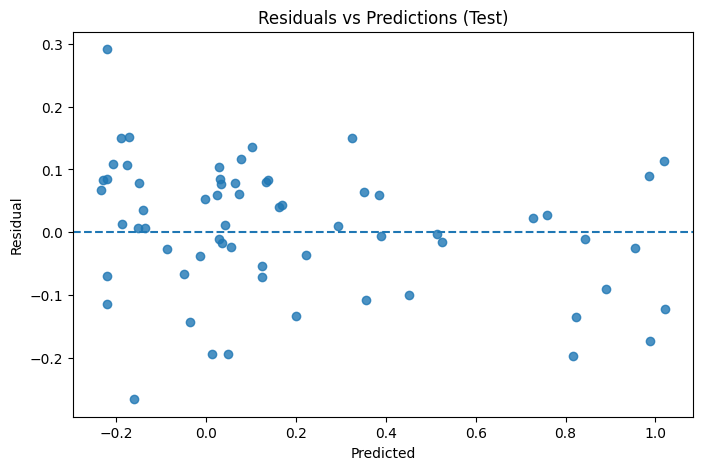

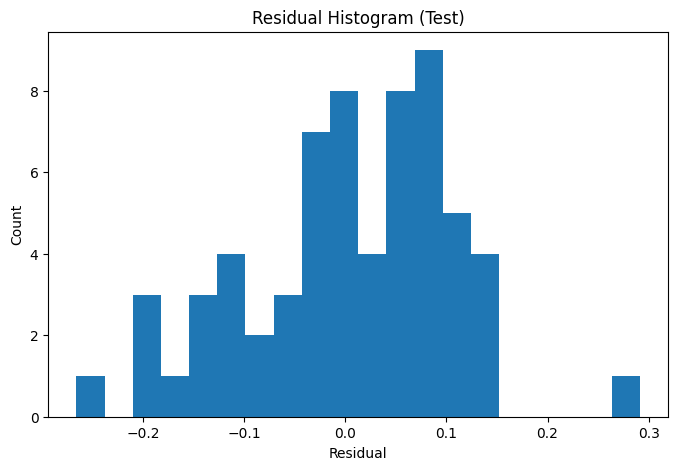

In [7]:

# 3.4 Residual analysis on test set
residuals = y_test - yhat_te

plt.figure(figsize=(8,5))
plt.scatter(yhat_te, residuals, alpha=0.8)
plt.axhline(0.0, linestyle="--")
plt.title("Residuals vs Predictions (Test)")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.show()

plt.figure(figsize=(8,5))
plt.hist(residuals, bins=20)
plt.title("Residual Histogram (Test)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()



## 4) Kernel Comparison

Compare **linear**, **polynomial**, and **RBF** kernels with modest hyperparameters (not exhaustively tuned). This highlights bias–variance trade-offs.


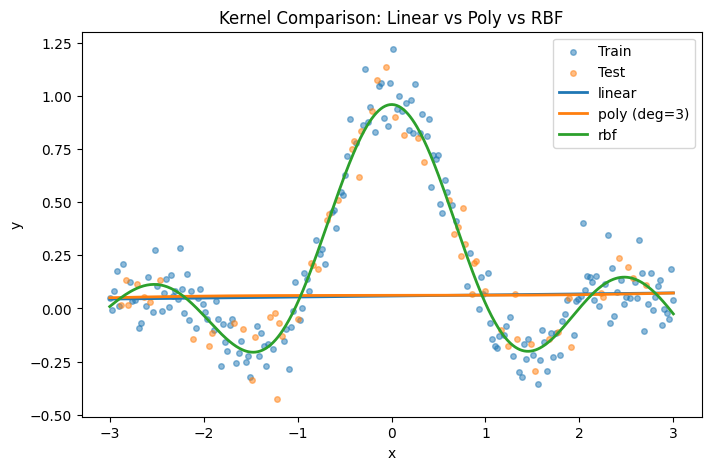

,Model,MAE_train,RMSE_train,R2_train,MAE_test,RMSE_test,R2_test
2,rbf,0.077895,0.098200,0.930058,0.073340,0.093748,0.933351
1,poly (deg=3),0.267246,0.386766,-0.084964,0.280614,0.387665,-0.139675
0,linear,0.267174,0.387539,-0.089305,0.280268,0.388549,-0.144880


In [8]:

kernels = [
    ("linear", SVR(kernel="linear", C=10.0, epsilon=0.05)),
    ("poly (deg=3)", SVR(kernel="poly", degree=3, C=10.0, epsilon=0.05, gamma="scale")),
    ("rbf", SVR(kernel="rbf", C=10.0, epsilon=0.05, gamma="scale")),
]

rows = []
plt.figure(figsize=(8,5))
plt.scatter(X_train, y_train, s=16, alpha=0.5, label="Train")
plt.scatter(X_test, y_test, s=16, alpha=0.5, label="Test")

Xd = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
for name, mdl in kernels:
    mdl.fit(X_train, y_train)
    metrics, _, _ = evaluate(mdl, X_train, y_train, X_test, y_test, label=name)
    rows.append(metrics)
    yhat_d = mdl.predict(Xd)
    plt.plot(Xd, yhat_d, linewidth=2, label=name)

plt.title("Kernel Comparison: Linear vs Poly vs RBF")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.show()

pd.DataFrame(rows).sort_values("RMSE_test")



## 5) Hyperparameter Effects: $C$ and $\epsilon$

- **$C$** controls the penalty for errors outside the tube. Larger $C$ reduces bias but can overfit.
- **$\epsilon$** sets tube width. Larger $\epsilon$ ignores small deviations (fewer support vectors), smaller $\epsilon$ fits more tightly.

We'll sweep a grid and visualize test RMSE.


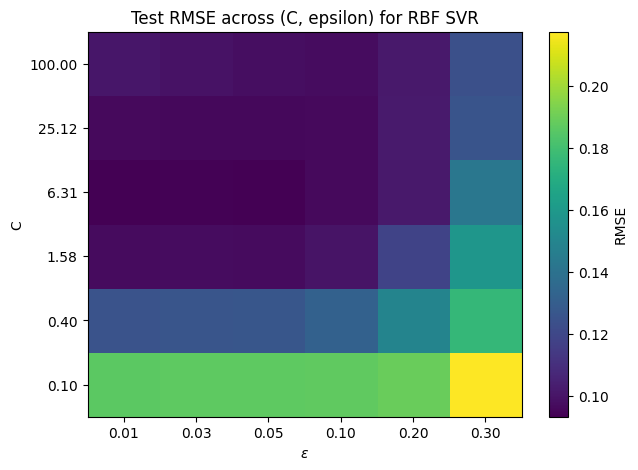

In [10]:
# Backward-compatible RMSE computation
def safe_rmse(y_true, y_pred):
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

Cs = np.logspace(-1, 2, 6)      # 0.1 ... 100
epsilons = np.array([0.01, 0.03, 0.05, 0.1, 0.2, 0.3])

rmse = np.zeros((len(Cs), len(epsilons)))

for i, C in enumerate(Cs):
    for j, eps in enumerate(epsilons):
        mdl = SVR(kernel="rbf", C=C, epsilon=eps, gamma="scale")
        mdl.fit(X_train, y_train)
        yhat = mdl.predict(X_test)
        rmse[i, j] = safe_rmse(y_test, yhat)

fig, ax = plt.subplots(figsize=(7,5))
im = ax.imshow(rmse, origin="lower", aspect="auto")
ax.set_xticks(range(len(epsilons)))
ax.set_xticklabels([f"{e:.2f}" for e in epsilons])
ax.set_yticks(range(len(Cs)))
ax.set_yticklabels([f"{c:.2f}" for c in Cs])
ax.set_xlabel(r"$\epsilon$")
ax.set_ylabel("C")
ax.set_title("Test RMSE across (C, epsilon) for RBF SVR")
plt.colorbar(im, ax=ax, label="RMSE")
plt.show()


## 6) Support Vectors vs. $\epsilon$

As $\epsilon$ grows, fewer points lie outside the tube, so SVR often uses **fewer support vectors** (sparser model).


In [11]:

eps_grid = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3]
rows = []

for eps in eps_grid:
    mdl = SVR(kernel="rbf", C=10.0, epsilon=eps, gamma="scale")
    mdl.fit(X_train, y_train)
    rows.append({"epsilon": eps, "n_support_vectors": mdl.support_.size})

df_sv = pd.DataFrame(rows)
df_sv


,epsilon,n_support_vectors
0,0.01,169
1,0.03,150
2,0.05,122
3,0.10,57
4,0.20,14
5,0.30,10


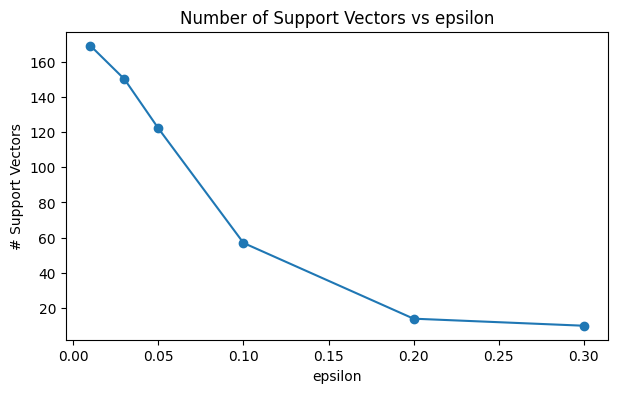

In [12]:

plt.figure(figsize=(7,4))
plt.plot(df_sv["epsilon"], df_sv["n_support_vectors"], marker="o")
plt.title("Number of Support Vectors vs epsilon")
plt.xlabel("epsilon")
plt.ylabel("# Support Vectors")
plt.show()



## 7) Key Takeaways

- SVR minimizes model complexity while ignoring small errors inside an $\epsilon$-tube.
- The **dual** enables kernels: $K(\mathbf{x},\mathbf{z})$ allows **nonlinear** regression.
- **$C$** (regularization) and **$\epsilon$** (tube width) are the most impactful hyperparameters.
- RBF kernel is a strong default; try linear/polynomial for structure or speed.

## References and Further Reading
- Vapnik, V. *The Nature of Statistical Learning Theory*. Springer, 1995.
- Smola, A., Schölkopf, B. "A tutorial on support vector regression" (2004).
- Scikit-learn User Guide — SVR.


In [13]:

import sklearn, sys
print("Best RBF-SVR parameters:", gcv.best_params_)
print("Python", sys.version)
print("NumPy", np.__version__)
print("pandas", pd.__version__)
print("scikit-learn", sklearn.__version__)


Best RBF-SVR parameters: {'C': 100.0, 'epsilon': 0.01, 'gamma': 1.0}
Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
NumPy 2.0.2
pandas 2.2.2
scikit-learn 1.6.1
